# Santa Clara County Airbnb Calendar Data Analysis and Visualization

In this analysis, I take a look at the Airbnb listing data on Santa Clara County, California, United States. The data set contains the availability and pricing information on all the Aribnb listings in Santa Clara from November 2019 to November 2020. I would like to analyze this dataset to gain insights to help Airbnb users to develop a better booking strategy when they travel to Santa Clara County and are in need for booking a room through Airbnb in the future.

I hope to derive detailed answers to the following questions from this analysis:

1. Where (which city) is the most/least expensive place?
2. Where (which city) has the highest review ratings?
3. Is paying extra cleaning fee worth it?

# Data Cleaning and Preprocessing

## Set up notebook and workspace

In [56]:
# Load watermark jupyterlab extension
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [57]:
# Import necessary packages
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from uszipcode import SearchEngine
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import seaborn as sns

%matplotlib inline

In [58]:
# Show package versions
%watermark -v -iv

pandas     0.25.3
seaborn    0.9.0
numpy      1.17.4
matplotlib 3.1.3
CPython 3.7.4
IPython 7.11.1


In [59]:
# Download and unzip the shapefile for creating the map plots of Santa Clara County
!wget -P ./map_data https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Boundaries/countyl010g_shp_nt00964.tar.gz
!tar -xzvf map_data/countyl010g_shp_nt00964.tar.gz -C ./map_data
!rm ./map_data/*.tar.gz

--2020-02-22 17:22:00--  https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Boundaries/countyl010g_shp_nt00964.tar.gz
Resolving prd-tnm.s3.amazonaws.com (prd-tnm.s3.amazonaws.com)... 52.218.212.170
Connecting to prd-tnm.s3.amazonaws.com (prd-tnm.s3.amazonaws.com)|52.218.212.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19608914 (19M) [application/x-gzip]
Saving to: ‘./map_data/countyl010g_shp_nt00964.tar.gz’

countyl010g_shp_nt0 100%[===================>]  18.70M  8.54MB/s    in 2.2s    

2020-02-22 17:22:02 (8.54 MB/s) - ‘./map_data/countyl010g_shp_nt00964.tar.gz’ saved [19608914/19608914]

countyl010g.dbf
countyl010g.prj
countyl010g.sbn
countyl010g.sbx
countyl010g.shp
countyl010g.shp.xml
countyl010g.shx
countyl010g.txt


In [60]:
# Load the Airbnb listing data
df = pd.read_csv(
    "http://data.insideairbnb.com/united-states/ca/santa-clara-county/2019-11-07/data/listings.csv.gz"
)

In [61]:
# Create a 'image' folder, if not not existed, for storing the plot outputs
!mkdir -p ./image

## First look at data

In [62]:
df.shape

(7658, 106)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7658 entries, 0 to 7657
Columns: 106 entries, id to reviews_per_month
dtypes: float64(24), int64(21), object(61)
memory usage: 6.2+ MB


In [64]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4952,https://www.airbnb.com/rooms/4952,20191107231003,2019-11-07,Butterfly Inn - Graceful Living !,Lovely garden setting in a serene and art-fill...,Very comfortable Queen bed and small desk in b...,Lovely garden setting in a serene and art-fill...,none,"Located in Professorville, Palo Alto, one of t...",...,f,f,moderate,f,f,5,0,5,0,0.60
1,11464,https://www.airbnb.com/rooms/11464,20191107231003,2019-11-08,Deluxe Private Studio-custom int.,Custom built Studio with exquisite design. Per...,Description A favorite for international corpo...,Custom built Studio with exquisite design. Per...,none,10 min. to Lucky's and Starbucks at El Camino ...,...,t,f,moderate,f,t,15,15,0,0,0.09
2,19181,https://www.airbnb.com/rooms/19181,20191107231003,2019-11-08,Majestic Room #1 with Sauna and Large Family Room,Enjoy your privacy in this spacious and luxuri...,This is a lock-off guest unit in the lower lev...,Enjoy your privacy in this spacious and luxuri...,none,We are located in a 5-minute walk to downtown ...,...,f,f,moderate,t,t,3,1,2,0,0.11
3,21373,https://www.airbnb.com/rooms/21373,20191107231003,2019-11-07,Bonsai Garden Inn in Professorville,Room in gracious home with beautiful garden. ...,"Bright, garden-facing room in beautiful home. ...",Room in gracious home with beautiful garden. ...,none,This room is in an ultra convenient location i...,...,f,f,moderate,f,f,5,0,5,0,2.16
4,23732,https://www.airbnb.com/rooms/23732,20191107231003,2019-11-07,Heart of Silicon Valley bdrm & bath,NaN,You'll have the room to yourself as well as a ...,You'll have the room to yourself as well as a ...,none,NaN,...,f,f,moderate,f,f,1,0,1,0,0.03


In [65]:
# Columns with the most missing values
df.isna().mean().sort_values().tail(20)

review_scores_value             0.187386
jurisdiction_names              0.191564
security_deposit                0.205145
space                           0.247323
host_about                      0.328415
house_rules                     0.333377
neighborhood_overview           0.378036
interaction                     0.409376
access                          0.414991
transit                         0.423087
notes                           0.487595
monthly_price                   0.910943
weekly_price                    0.916166
square_feet                     0.995952
thumbnail_url                   1.000000
license                         1.000000
medium_url                      1.000000
neighbourhood_group_cleansed    1.000000
host_acceptance_rate            1.000000
xl_picture_url                  1.000000
dtype: float64

In [66]:
# Columns contain keywords "review"
df.filter(like="score", axis=1).isna().mean()

review_scores_rating           0.186994
review_scores_accuracy         0.187125
review_scores_cleanliness      0.187125
review_scores_checkin          0.187386
review_scores_communication    0.187255
review_scores_location         0.187255
review_scores_value            0.187386
dtype: float64

In [67]:
# Numerical columns
df.select_dtypes(exclude="object").columns

Index(['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url',
       'host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'c

In [68]:
# Str columns
df.select_dtypes(include="object").columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review', 'requires_license', 'jurisdictio

## Clean up price data

In [69]:
df["price"].head()

0     $90.00
1     $85.00
2    $100.00
3     $99.00
4    $299.00
Name: price, dtype: object

We need to convert the 'price' column from string to numerical type

In [70]:
df["price"] = df["price"].replace("[^.0-9]", "", regex=True).astype(float)

## Clean up location data
We are interested in analyzing listing trend by locations (city/zipcode), so let's exam if we have clean location location data

In [71]:
# check if there are missing values in the location columns
df[["city", "zipcode", "latitude", "longitude"]].isna().sum()

city          19
zipcode      395
latitude       0
longitude      0
dtype: int64

### Dealing with missing data

There are missing data in `city` and `zipcode` columns. However, we have the coordinates for all the listings. We can use the `uszipcode` python package to generate the missing data in `city` and `column` later

In [72]:
# check if the city data is clean
df["city"].value_counts()

San Jose              3165
Palo Alto              833
Mountain View          820
Sunnyvale              816
Santa Clara            703
Cupertino              335
Milpitas               306
Campbell               130
Los Gatos              128
Los Altos               94
Saratoga                85
Morgan Hill             59
Los Altos Hills         54
Gilroy                  37
Monte Sereno            19
San Martin              16
Menlo Park               6
Palo Alto                6
Stanford                 5
San Jose                 4
Sunnyvale                2
Hollister                2
洛斯阿尔托斯                   1
Santa Clara County       1
Mountain View            1
los Altos                1
帕洛阿尔托                    1
Danville                 1
santa clara              1
East Palo Alto           1
Campbell                 1
Milpitas                 1
San Francisco            1
san jose                 1
Los Gatos                1
Sanjose                  1
Name: city, dtype: int64

The `city` data column needs to be cleaned up if we want to use it as a catagorical variable. 
- capitalization error: san jose -> San Jose
- foreign language: 帕洛阿尔托 -> Palo Alto

In [73]:
# check if the zipcode column is clean

df["zipcode"].value_counts()

94306       369
95112       344
95014       307
95035       305
94043       291
           ... 
CA 95134      1
94526         1
94028         1
94115         1
95009         1
Name: zipcode, Length: 72, dtype: int64

In addition to the problem of having 395 missing values, the `zipcode` column also contain data with inconsistent format:
- multiple zipcode `9503\n9503\n95035`
- more than 5 digits `95032-4635`

Since the map coordinates data are available for all the listings/rows in the dataframe, we can easily fill in the missing data and clean up the data in the `city` and `zipcode` columns with the `uszipcode` package 

In [74]:
# use uszipcode package to get zipcode and city info from coordinates
search = SearchEngine(simple_zipcode=True)

city_list = []
zipcode_list = []

# Loop throuh each row, and get updated city/zipcode info based on listing coordinates
for lat, lng in zip(df["latitude"], df["longitude"]):
    res = search.by_coordinates(lat=lat, lng=lng, radius=10, returns=1)[0]
    city = res.major_city
    zipcode = res.zipcode

    city_list.append(city)
    zipcode_list.append(zipcode)

# add new_city and new_zipcode columns to the df for later use
df["new_city"] = city_list
df["new_zipcode"] = zipcode_list

# Analyses and Visualizations

## All Listings

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

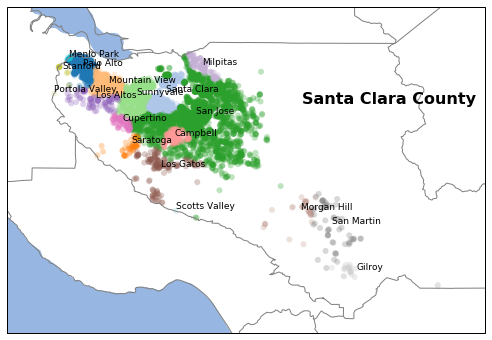

In [75]:
# load the shape file with US county coordinate info
fname = "map_data/countyl010g.shp"
reader = shpreader.Reader(fname)
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

# draw a map with US county lines
plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN.with_scale("10m"))
ax.add_feature(cfeature.LAKES.with_scale("10m"))
ax.add_feature(COUNTIES, facecolor="None", edgecolor="gray")

# zoom-in to the Santa Clara County
BBox = [
    df.longitude.min() - 0.1,
    df.longitude.max() + 0.1,
    df.latitude.min() - 0.1,
    df.latitude.max() + 0.1,
]
ax.set_extent(BBox)

# Set colors for different cities within Santa Clara County
cities = df["new_city"].unique()
colors = [plt.cm.tab20(i / float(len(cities) - 1)) for i in range(len(cities))]

for i, city in enumerate(cities):
    plt.scatter(
        "longitude",
        "latitude",
        data=df.loc[df.new_city == city, :],
        c=np.array(list(colors[i])),
        label=str(city),
        edgecolors="None",
        linewidths=0.2,
        alpha=0.3,
    )


# Add text anotation for all the cities
style = dict(size=9, color="black")
lat = df.groupby("new_city").mean()["latitude"]
lon = df.groupby("new_city").mean()["longitude"]
cities = lat.index.to_list()

# Add text anotation for Santa Clara County
ax.text(
    df["longitude"].mean() + 0.3,
    df["latitude"].mean(),
    "Santa Clara County",
    fontsize=16,
    fontweight="bold",
)


for i, j, k in zip(lon, lat, cities):
    ax.text(i, j, k, **style, va="bottom", ha="left")

plt.savefig("image/map.png", dpi=200, bbox_inches="tight", pad_inches=0.1)

## Room Types

### Map: Room Type by Location

In [76]:
df.room_type.value_counts()

Entire home/apt    3656
Private room       3553
Shared room         432
Hotel room           17
Name: room_type, dtype: int64

In [77]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.8588235294117647

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0.5, 1.0, 'Santa Clara County Airbnb Listings by Room Type')

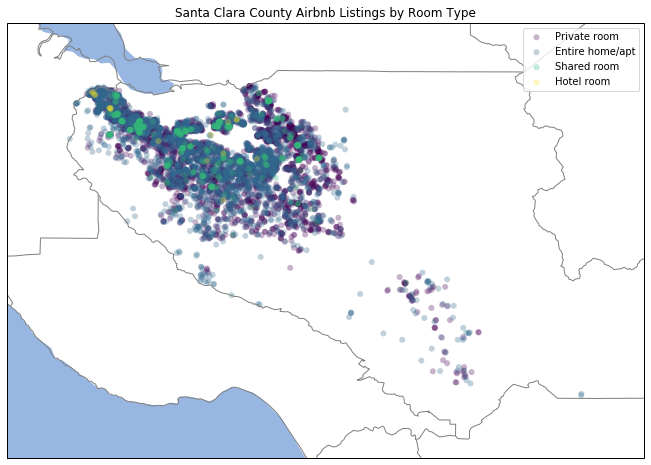

In [78]:
# draw a map with US county lines
plt.figure(figsize=(18, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN.with_scale("10m"))
ax.add_feature(cfeature.LAKES.with_scale("10m"))
ax.add_feature(COUNTIES, facecolor="None", edgecolor="gray")

ax.set_extent(BBox)

# Set colors for different cities within Santa Clara County
room_types = df["room_type"].unique()
colors = [
    plt.cm.viridis(i / float(len(room_types) - 1)) for i in range(len(room_types))
]

for i, room_type in enumerate(room_types):
    plt.scatter(
        "longitude",
        "latitude",
        data=df.loc[df.room_type == room_type, :],
        c=colors[i],
        label=str(room_type),
        edgecolors="None",
        linewidths=0.2,
        alpha=0.3,
    )


ax.legend()
plt.title("Santa Clara County Airbnb Listings by Room Type")

### Pie Chart: Room Types

In [79]:
df.groupby("room_type").size().reset_index(name="counts")

,room_type,counts
0,Entire home/apt,3656
1,Hotel room,17
2,Private room,3553
3,Shared room,432


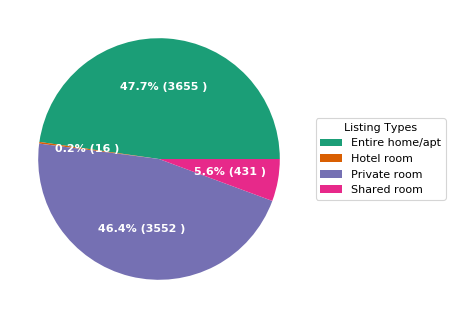

In [80]:
df_type = df.groupby("room_type").size().reset_index(name="counts")

# Draw Plot
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"), dpi=80)

data = df_type["counts"]
categories = df_type["room_type"]


def func(pct, allvals):
    absolute = int(pct / 100.0 * np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)


wedges, texts, autotexts = ax.pie(
    data,
    autopct=lambda pct: func(pct, data),
    textprops=dict(color="w"),
    colors=plt.cm.Dark2.colors,
    startangle=0,
)

# Decoration
ax.legend(
    wedges,
    categories,
    title="Listing Types",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)
plt.setp(autotexts, size=10, weight=700)
# ax.set_title("Santa Clara County Airbnb Listing Types")
plt.savefig("image/room_types.png", dpi=200,
            bbox_inches="tight", pad_inches=0.1)

## Average Price and Location

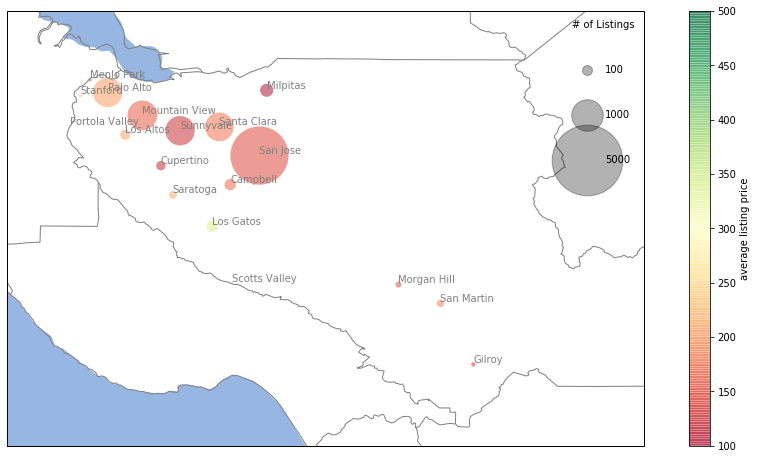

In [81]:
# Extract the data we're interested in
lat = df.groupby("new_city").mean()["latitude"]
lon = df.groupby("new_city").mean()["longitude"]
avg_price = df.groupby("new_city").mean()["price"]
listing_count = df.groupby("new_city").count()["latitude"]
cities = lat.index.to_list()

# draw a map with US county lines
plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN.with_scale("10m"))
ax.add_feature(cfeature.LAKES.with_scale("10m"))
ax.add_feature(COUNTIES, facecolor="None", edgecolor="gray")

# zoom-in to the Santa Clara County
BBox = [
    df.longitude.min() - 0.1,
    df.longitude.max() + 0.1,
    df.latitude.min() - 0.1,
    df.latitude.max() + 0.1,
]
ax.set_extent(BBox)


# Scatter the points, using size and color but no label
plt.scatter(
    lon,
    lat,
    label=None,
    c=avg_price,
    cmap="RdYlGn",
    s=listing_count,
    linewidth=0,
    alpha=0.5,
)
plt.axis(aspect="equal")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(label="average listing price")
plt.clim(100, 500)

# create a legend:
# plot empty lists with the desired size and label
for count in [100, 1000, 5000]:
    plt.scatter([], [], c="k", alpha=0.3, s=count, label=str(count))
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=3.5, title="# of Listings")

# Add text anotation for all the cities
style = dict(size=10, color="gray")

for i, j, k in zip(lon, lat, cities):
    ax.text(i, j, k, **style, va="bottom", ha="left")

# plt.title("Santa Clara County Airbnb Listings by City: Count and Price")
plt.savefig(
    "image/counts_by_location.png", dpi=200, bbox_inches="tight", pad_inches=0.1
)

### Table: Average Price by Room Type and City

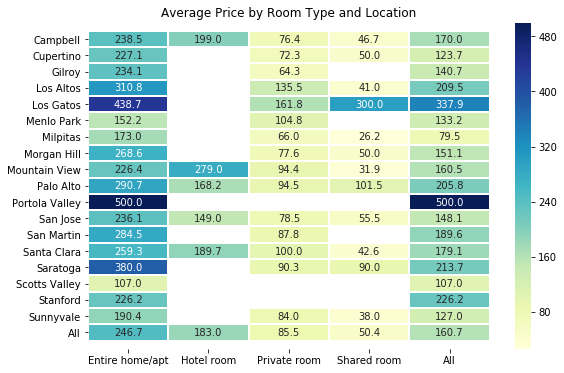

In [82]:
# create a pivot table for plotting
table = pd.pivot_table(
    df,
    values="price",
    index="new_city",
    columns="room_type",
    aggfunc="mean",
    margins=True,
)

# plot table as heatmap
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(
    table,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=1,
    xticklabels=table.columns.to_list(),
    yticklabels=table.index.to_list(),
)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Average Price by Room Type and Location")
plt.savefig(
    "image/table:price_by_location.png", dpi=200, bbox_inches="tight", pad_inches=0.1
)

In [83]:
d1 = table[table["All"] < 160.7].index

### Table: Listing Count by Room Type and City

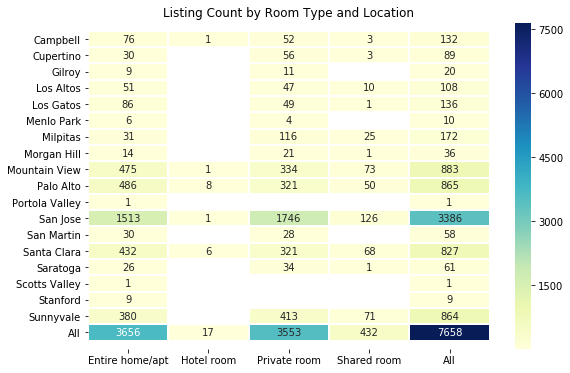

In [84]:
# create a pivot table for plotting
table = pd.pivot_table(
    df,
    values="price",
    index="new_city",
    columns="room_type",
    aggfunc="count",
    margins=True,
)

# plot table as heatmap
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(table, annot=True, fmt="g", cmap="YlGnBu", linewidths=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Listing Count by Room Type and Location",)
plt.savefig(
    "image/table:counts_by_location.png", dpi=200, bbox_inches="tight", pad_inches=0.1
)

## Review Scores

### Table: Average Review Scores by Room Type and City 

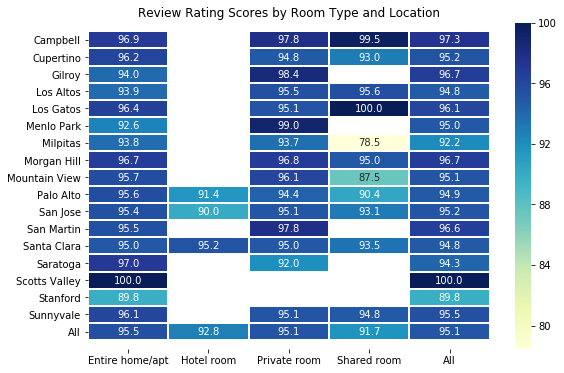

In [85]:
# create a pivot table for plotting
table = pd.pivot_table(
    df,
    values="review_scores_rating",
    index="new_city",
    columns="room_type",
    aggfunc="mean",
    margins=True,
)

# plot table as heatmap
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Review Rating Scores by Room Type and Location")
plt.savefig(
    "image/table:review_by_city_and_type.png",
    dpi=200,
    bbox_inches="tight",
    pad_inches=0.1,
)

### Table: Normalized Review Scores (rating/price) by Room Type and Location

Text(0.5, 1, 'Normalized Review Rating by Room Type and Location')

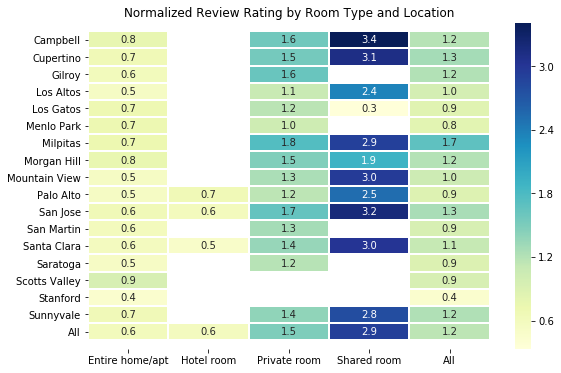

In [86]:
# create a temporary dataframe storing the city, room type, rating, and price info
temp_df = df[["review_scores_rating", "price", "new_city", "room_type"]].copy()
temp_df.dropna(inplace=True)
temp_df["rating_to_price"] = temp_df["review_scores_rating"] / temp_df["price"]
table = pd.pivot_table(
    data=temp_df,
    values="rating_to_price",
    index="new_city",
    columns="room_type",
    margins=True,
    aggfunc="mean",
)

# plot table as heatmap
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Normalized Review Rating by Room Type and Location")

## Cleaning Fee

### Percentages of Listings that Charge Seperate Cleaning Fees

In [87]:
# convert cleaning_fee column from str to float
df["cleaning_fee"] = df["cleaning_fee"].replace(
    "[^.0-9]", "", regex=True).astype(float)

In [88]:
# create temporary dataframe with needed columns for analysis/plot
temp_df = df[
    [
        "review_scores_rating",
        "price",
        "new_city",
        "room_type",
        "cleaning_fee",
        "review_scores_cleanliness",
    ]
].copy()
temp_df["seperate_cleaning_fee"] = temp_df["cleaning_fee"].notna()

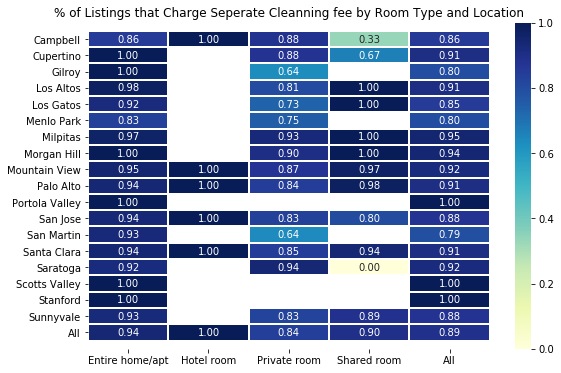

In [89]:
# create a pivot table for plotting
table = pd.pivot_table(
    data=temp_df,
    values="seperate_cleaning_fee",
    index="new_city",
    columns="room_type",
    margins=True,
)

# plot table as heatmap
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title(
    "% of Listings that Charge Seperate Cleanning fee by Room Type and Location"
)

plt.savefig(
    "image/table:cleaning_fee1.png", dpi=200, bbox_inches="tight", pad_inches=0.1
)

### Average Cleaning Fee by Room Type and Location

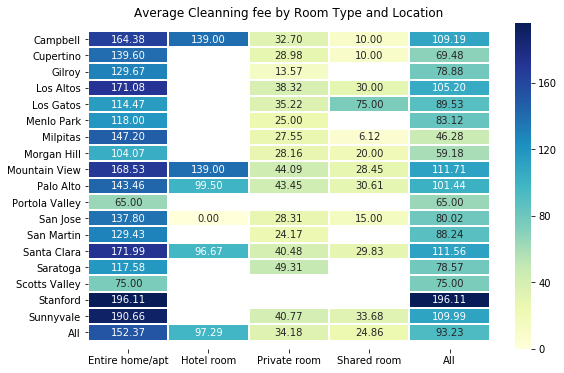

In [90]:
# create a pivot table for plotting
table = pd.pivot_table(
    data=temp_df,
    values="cleaning_fee",
    index="new_city",
    columns="room_type",
    aggfunc="mean",
    margins=True,
)

# plot table as heatmap
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Average Cleanning fee by Room Type and Location")
plt.savefig(
    "image/table:cleaning_fee2.png", dpi=200, bbox_inches="tight", pad_inches=0.1
)

### Does Cleaning Fee Result in Higher Guest Satisfication

In [91]:
# Average cleanliness scores by whether cleaning fee is charged
temp_df.groupby(["seperate_cleaning_fee"])["review_scores_cleanliness"].agg(
    ["mean", "count"]
)

,mean,count
seperate_cleaning_fee,,
False,9.492027,439
True,9.564293,5786


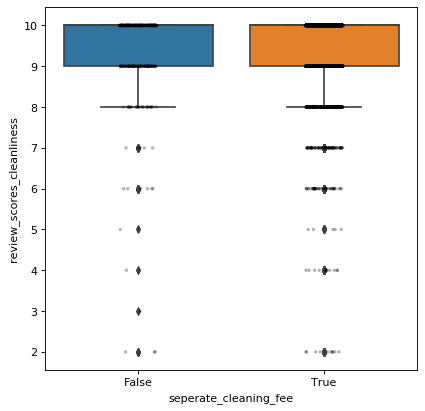

In [92]:
# boxplot and stripplot of cleanliness review scores

plt.figure(figsize=(6, 6), dpi=80)
sns.boxplot(x="seperate_cleaning_fee",
            y="review_scores_cleanliness", data=temp_df)
sns.stripplot(
    x="seperate_cleaning_fee",
    y="review_scores_cleanliness",
    data=temp_df,
    color="black",
    size=3,
    jitter=1,
    alpha=0.3,
)

plt.savefig(
    "image/table:cleaning_fee3.png", dpi=200, bbox_inches="tight", pad_inches=0.1
)